## Where is my asteroid? How to calculate ephemerides

In this exercise we'll show how to use the python interface to JPL's Horizons package to make accurate predictions for asteroid positions. We'll also show how to query the Gaia catalog to compare to the positions of nearby stars, and illustrate all this by examining the upcoming Polymele occultation.

[JPL Horizons](https://ssd.jpl.nasa.gov/horizons/) is NASA's toolkit for solar system dynamics. It has a complete database, updated contantly, of all known solar system objects, including spacecraft. (Want to know where that Tesla Roadster that was launched into space a few years ago is now? Horizons can tell you!) It also has sophisticated tools for carrying out dynamical calculations at a level of precision suitable for planning missions such as Lucy. But backyard astronomers can use it, too, to help find solar system objects visible from their location.

An ephemeris (plural: ephemerides) is a table of positions and times. Historically, they were printed in books and used by farmers, navigators, astrologers, and skywatchers. The earliest ephemerides date from Babylonian times. Today they are most commonly generated on-demand by computers. An ephemeris table often contains additional information such as an object's magnitude (brightness), rate of motion, phase, elongation from the sun and the moon, elevation above the horizon, rising and setting times, etc. They are almost always calculated for a given location on earth. Even for objects as distant as Jupiter Trojans, parallax due to an observer's location on earth makes a detectable difference to an object's position. (That is why occultations are not visible everywhere!)

In [2]:
import numpy as np
from astroquery.jplhorizons import Horizons
from astroquery.gaia import Gaia

from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
astname = 'Polymele'

First we'll calculate and plot the position of Polymele at daily intervals between now and the Lucy encounter date in September, 2027, as observed from Ann Arbor. We store times as astropy `Time` objects.

Many observatories and cities have pre-defined location codes that Horizons understands. A complete list is given at https://minorplanetcenter.net/iau/lists/ObsCodesF.html. One particularly important location code is the earth geocenter, location code 500. Obviously it's not possible to observe from this location, but it's a useful point of reference, because there are no effects from observer parallax or earth's rotation.

In [4]:
startdate = Time('2023-01-01 00:00:00', scale='utc', format='iso')
enddate = Time('2027-09-15 00:00:00', scale='utc', format='iso')

# Ann Arbor's location code is 767
ephem = Horizons(id=astname, location='767',
                epochs={'start':startdate.iso, 
                        'stop':enddate.iso, 
                        'step':'1d'}).ephemerides()

/Users/gerdes/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/gerdes/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


The call to Horizons returns the requested ephemeris as an astropy `Table`. Personally I find pandas dataframes more widespread and easy to work with; fortunately it's easy to convert it to that format. You can see that Horizons returns a great deal of information in this ephemeris. 

In [5]:
ephem_df = ephem.to_pandas()
print(ephem_df.columns)
ephem_df.head()

Index(['targetname', 'datetime_str', 'datetime_jd', 'H', 'G', 'solar_presence',
       'flags', 'RA', 'DEC', 'RA_app', 'DEC_app', 'RA_rate', 'DEC_rate', 'AZ',
       'EL', 'AZ_rate', 'EL_rate', 'sat_X', 'sat_Y', 'sat_PANG',
       'siderealtime', 'airmass', 'magextinct', 'V', 'surfbright',
       'illumination', 'illum_defect', 'sat_sep', 'sat_vis', 'ang_width',
       'PDObsLon', 'PDObsLat', 'PDSunLon', 'PDSunLat', 'SubSol_ang',
       'SubSol_dist', 'NPole_ang', 'NPole_dist', 'EclLon', 'EclLat', 'r',
       'r_rate', 'delta', 'delta_rate', 'lighttime', 'vel_sun', 'vel_obs',
       'elong', 'elongFlag', 'alpha', 'lunar_elong', 'lunar_illum',
       'sat_alpha', 'sunTargetPA', 'velocityPA', 'OrbPlaneAng',
       'constellation', 'TDB-UT', 'ObsEclLon', 'ObsEclLat', 'NPole_RA',
       'NPole_DEC', 'GlxLon', 'GlxLat', 'solartime', 'earth_lighttime',
       'RA_3sigma', 'DEC_3sigma', 'SMAA_3sigma', 'SMIA_3sigma', 'Theta_3sigma',
       'Area_3sigma', 'RSS_3sigma', 'r_3sigma', 'r_rate_3sigm

,targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA,DEC,RA_app,...,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
0,15094 Polymele (1999 WB2),2023-Jan-01 00:00,2459945.5,11.81,0.22,,m,104.88567,35.63300,105.27280,...,79.4109,0.000008,0.34,1.24,0.000530,47.5644,-5.907638,2.6429,102.1141,11.5320
1,15094 Polymele (1999 WB2),2023-Jan-02 00:00,2459946.5,11.81,0.22,,m,104.71562,35.66557,105.10299,...,80.7678,0.000008,0.34,1.25,0.000539,47.6594,-5.830608,2.6141,102.0908,11.5476
2,15094 Polymele (1999 WB2),2023-Jan-03 00:00,2459947.5,11.81,0.22,,m,104.54525,35.69692,104.93286,...,82.1462,0.000008,0.34,1.25,0.000548,47.7544,-5.753554,2.6054,102.0675,11.5627
3,15094 Polymele (1999 WB2),2023-Jan-04 00:00,2459948.5,11.81,0.22,,m,104.37467,35.72702,104.76254,...,83.5447,0.000008,0.34,1.25,0.000557,47.8494,-5.676488,2.6170,102.0443,11.5774
4,15094 Polymele (1999 WB2),2023-Jan-05 00:00,2459949.5,11.81,0.22,,m,104.20405,35.75585,104.59217,...,84.9615,0.000008,0.34,1.25,0.000567,47.9443,-5.599418,2.6487,102.0211,11.5915


Now we are ready to plot the on-sky position of Polymele over the roughly 5-year period we requested. We'll use the object's visual magnitude (V) as the color scale.

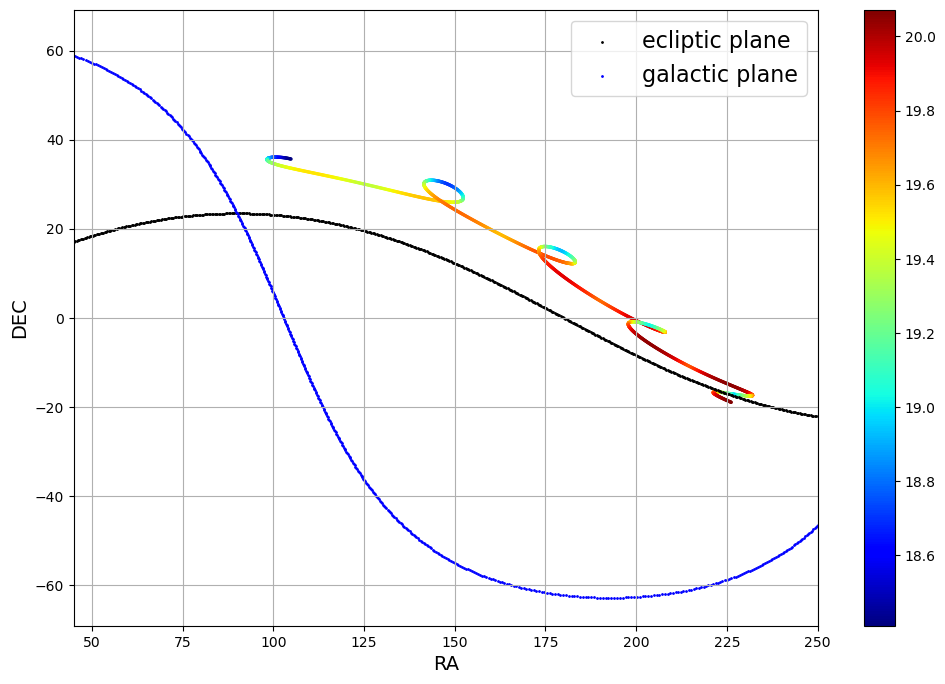

In [6]:
# Generate points for the ecliptic so we can include it in the plot
ecliptic = SkyCoord(np.linspace(0,360,1000), np.zeros(1000), unit=(u.deg, u.deg), frame='geocentrictrueecliptic').transform_to('icrs')
galactic = SkyCoord(np.linspace(0,360,1000), np.zeros(1000), unit=(u.deg, u.deg), frame='galactic').transform_to('icrs')

fig, ax = plt.subplots(1, figsize=(12,8))
sc = ax.scatter(ephem_df.RA, ephem_df.DEC, s=2, c=ephem_df.V, cmap='jet')
ax.scatter(ecliptic.ra.deg, ecliptic.dec.deg, color='k', s=1, label='ecliptic plane')
ax.scatter(galactic.ra.deg, galactic.dec.deg, color='b', s=1, label='galactic plane')
plt.colorbar(sc)
ax.grid()
ax.set_xlabel("RA", fontsize=14)
ax.set_ylabel("DEC", fontsize=14)
ax.set_xlim([45, 250])
ax.legend(fontsize=16)

This figure is very characteristic of the long-term motion of an outer solar system object. We are seeing alternating periods of prograde and retrograde motion as the earth passes Polymele once per year on the "inside track". This is superimposed on Polymele's own 11.74-year orbital period. Polymele's orbit has a relatively high 13 degree inclination, which accounts for the differing appearance of the "curlicues" as its distance above the ecliptic plane changes. Polymele's visual magnitude is also varying within about a 1.5-mag range based on the varying geometry between Polymele, the earth, and the sun.  

Two other things to note:

*   Earlier times (closer to now) are on the left in Polymele's trajectory above, and later times (closer to the encounter) are on the right. Note that Polymele is moving closer to the ecliptic plane during the next 5 years, and will be very close to the ecliptic at the time of the encounter. This is why it can be encountered in the first place: Lucy's path remains close to the ecliptic plane.
*   Marc Buie mentioned in our discussion the other day that Polymele occultations will occur less frequently in the next few years. This figure shows why: its path is also taking it further away from the galactic plane (blue curve), towards regions of lower stellar density.


# The February, 2023 occultation

Now let's turn to a much shorter time window, the hour surrounding the occultation that will take place on Feb. 4, 2023 at geocentric mid-time 01:39:43 UT. We'll choose a 1-hour window centered on this time, and consider observations made from two locations: Earth's geocenter (for reference), and our tentative location near Salina, Kansas. There is no pre-defined code for this location, but we can describe it to Horizons by hand. (I looked up the lat, lon for a point near downtown from Google Maps, and got the elevation from Wikipedia.) (Why does elevation matter? It affects how atmospheric refraction is calculated, which affects the apparent position of the asteroid.)




In [7]:
startdate = Time('2023-02-04 01:00:00', scale='utc', format='iso')
enddate   = Time('2023-02-04 02:00:00', scale='utc', format='iso')

Salina_KS = {'lat':38.4031, 'lon':-97.6652, 'elevation':444} # This point is for MacPherson, KS, closer to the centerline

In [8]:
#Compute ephemeris positions for two observing locations: Earth geocenter (location=500) and Liberal, KS (location defined above)
# We will generate the ephemeris at 1-second intervals (=3600 time steps over one hour) and request high-precision on the ephemeris calculation.
ephem_geocenter = Horizons(id=astname, location='500',
                          epochs={'start':startdate.iso, 
                                  'stop':enddate.iso, 
                                  'step':'3600'}).ephemerides(extra_precision=True)
ephem_KS = Horizons(id=astname, location=Salina_KS,
                          epochs={'start':startdate.iso, 
                                  'stop':enddate.iso, 
                                  'step':'3600'}).ephemerides(extra_precision=True)

In [9]:
# Store the positions as astropy SkyCoords
pos_geocenter = SkyCoord(ephem_geocenter['RA'], ephem_geocenter['DEC'], frame='icrs', unit=(u.deg, u.deg))
pos_KS = SkyCoord(ephem_KS['RA'], ephem_KS['DEC'], frame='icrs', unit=(u.deg, u.deg))


Since this is an occultation, we also care about the stars in the area. The state-of-the-art stellar catalog comes from the Gaia satellite, which has measured the position and proper motions of nearly 1.5 billion stars. We will query this database, using the midpoint and range of the asteroid's position to define the region for our query. (If you are not careful and request the Gaia sources over too large of an area, your query may return an enormous number of sources, or return an error!) The result is again returned as an astropy Table which we will again convert to a pandas dataframe. 


In [10]:
# Get the stars in this area from the Gaia catalog
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
ra_mid, dec_mid = np.average(pos_geocenter.ra.deg), np.average(pos_geocenter.dec.deg)
center = SkyCoord(ra=ra_mid, dec=dec_mid, unit=(u.degree, u.degree), frame='icrs')

ra_wid = np.max(pos_geocenter.ra.deg) - np.min(pos_geocenter.ra.deg)
dec_wid = np.max(pos_geocenter.dec.deg) - np.min(pos_geocenter.dec.deg)
width = u.Quantity(ra_wid, u.deg)
height = u.Quantity(dec_wid, u.deg)
result = Gaia.query_object_async(coordinate=center, width=width, height=height)
result_df = result.to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


In [11]:
print(result_df.columns)
result_df[['DESIGNATION','ra','dec','ref_epoch','pmra', 'pmdec','parallax','phot_g_mean_mag']].head()


Index(['dist', 'solution_id', 'DESIGNATION', 'source_id', 'random_index',
       'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error',
       ...
       'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper',
       'ag_gspphot', 'ag_gspphot_lower', 'ag_gspphot_upper',
       'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
       'libname_gspphot'],
      dtype='object', length=153)


,DESIGNATION,ra,dec,ref_epoch,pmra,pmdec,parallax,phot_g_mean_mag
0,Gaia DR3 942257658000993664,99.728803,36.024421,2016.0,3.265287,-1.180670,0.682484,18.614342
1,Gaia DR3 942258409619588992,99.727726,36.024223,2016.0,3.179665,-1.379876,0.848283,13.290937


The query returned only two stars. Again you can see that there is a very large amount of information about each star in the catalog. We care primarily about the star's RA, DEC, proper motion, and magnitude (`phot_g_mean_mag`). For occultations, we need to be be super-precise about the star's position, so we will next apply Gaia's corrections for the star's proper motion. 

In [12]:
# Here we apply the Gaia proper motion corrections to the stars. (They have moved since Gaia measured them, but the proper motion corrections account for that.)
distance = Distance(parallax=result_df['parallax'].values*u.mas)
stars = SkyCoord(ra=result_df.ra.values * u.deg,
             dec=result_df.dec.values * u.deg,
             distance=distance,
             pm_ra_cosdec=result_df.pmra.values * u.mas/u.yr,
             pm_dec=result_df.pmdec.values * u.mas/u.yr,
             obstime=Time(result_df.ref_epoch.values, format='jyear',
                          scale='tcb'))
stars_tonight = stars.apply_space_motion(Time('2023-02-04', format='iso', scale='utc'))
result_df['ra_current'] = stars_tonight.ra.deg
result_df['dec_current'] = stars_tonight.dec.deg

In [13]:
print(distance.lightyear)

[4778.96208014 3844.89851383]


In [14]:
# Add columns to the table showing the minimum separation from Polymele's path, and the time at which this occurs. We do this
# with the helper function below:
def sep_min(pos_star, ephem):
  pos_asteroid = SkyCoord(ephem['RA'], ephem['DEC'], unit=(u.deg, u.deg), frame='icrs')
  sep = pos_asteroid.separation(pos_star).arcsec
  sep_min = np.min(sep)
  min_index = np.argmin(sep)     # index into the array of min separation
  t_min = ephem['datetime_str'][min_index] # time of min separation
  return sep_min, t_min

result_df['sep_min'] = result_df.apply(lambda row: sep_min(SkyCoord(row['ra_current'], row['dec_current'], unit=(u.deg, u.deg), frame='icrs'), ephem_KS)[0], axis=1)
result_df['t_min'] = result_df.apply(lambda row: sep_min(SkyCoord(row['ra_current'], row['dec_current'], unit=(u.deg, u.deg), frame='icrs'), ephem_KS)[1], axis=1)
result_df[['source_id','ra','dec','ra_current','dec_current','phot_g_mean_mag','sep_min','t_min']].head()

,source_id,ra,dec,ra_current,dec_current,phot_g_mean_mag,sep_min,t_min
0,942257658000993664,99.728803,36.024421,99.728811,36.024418,18.614342,0.505558,2023-Feb-04 01:30:44.000
1,942258409619588992,99.727726,36.024223,99.727734,36.024221,13.290937,0.060573,2023-Feb-04 01:44:46.000


The above table summarizes the important information about the occultation! There are two Gaia stars nearby, the first with mag 18.6 and the second, brighter one, with mag 13.3. Polymele most closely approaches the mag 13.3 star, passing within 0.08 arcseconds at approximately 01:45:33 UT. 

Both the min separation (which should be nearly zero) and the time (which should be about a minute earlier) are very slightly off -- which could happen for a number of subtle reasons -- but this is not bad!

<b>Update 1/25/23</b>: Our calculation above misses by just a bit because the orital elements for Polymele are not as up-to-date as the ones the Lucy team is using. I've obtained this new orbital solution from the Lucy team, and the result is much closer (I calculate the centerline to be about 10km away from the Lucy team's result), and the occultation time comes about 45 seconds earlier, as it should. This calculation takes a bit more software technology since we can't grab everything from Horizons, but we will learn that as we go along.



---


Let's plot the trajectory as seen from our observing site, and the earth geocenter. We'll only plot the target star. 

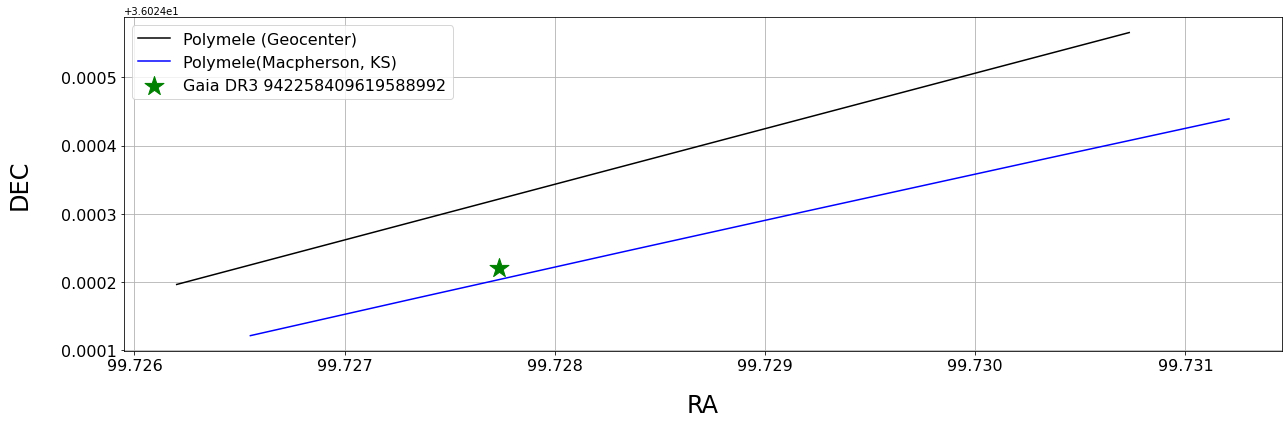

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(pos_geocenter.ra.deg, pos_geocenter.dec.deg, color='black', label='Polymele (Geocenter)')
ax.plot(pos_KS.ra.deg, pos_KS.dec.deg, color='blue', label='Polymele(Macpherson, KS)')
ax.scatter(result_df['ra_current'][1], result_df['dec_current'][1], s=400, marker='*', color='green', label=f"{result['DESIGNATION'][1]}")
ax.tick_params(labelsize=16)
ax.set_xlabel('RA', fontsize=24, labelpad=20)
ax.set_ylabel('DEC', fontsize=24, labelpad=30)
ax.grid()
ax.legend(fontsize=16)
fig.tight_layout()

You can clearly see the effect of parallax -- the apparent position of Polymele from the earth geocenter is very different! Note that the two lines are not exactly parallel--this is because the relative parallax between Kansas and the earth center changes over the course of one hour due to the earth's rotation. (With the updated orbit for Polymele, the track passes right through the star.)

Finally, let's use our ephemeris look at some of the other observing circumstances for that night. We will grab the row from the ephemeris that corresponds to our calculated time for the event.

In [ ]:
t_occultation = result_df.t_min.values[1] # the time at which the occultation occurs, calculated above.
ephem_KS_df = ephem_KS.to_pandas()        # convert to a pandas dataframe because I like it that way. 
ephem_occultation = ephem_KS_df.loc[ephem_KS_df.datetime_str==t_occultation]

In [ ]:
cols = ['EL','AZ','RA','DEC','constellation','V','airmass','r','elong','lunar_elong','lunar_illum']
ephem_occultation[cols].head()

,EL,AZ,RA,DEC,constellation,V,airmass,r,elong,lunar_elong,lunar_illum
2686,60.147735,82.771219,99.727736,36.024204,Aur,18.741,1.152,4.835836,141.5309,20.3,97.4756


This tells us that the star will be 57 degrees above the horizon, nearly in the east (azimuth=79 degrees, where north = 0 and east = 90), in the constellation Auriga. This relatively high elevation is good and means that we won't be looking through lots of air (airmass = 1.18, where zenith = 1.0). Polymele will be 4.83 AU from the sun at that point, and will have a visual magnitude of 18.7. This is considerably too faint to be seen by the small telescopes we'll be using: we will be able to see the 13.3 mag star, but not Polymele itself. (Remember that Polymele is the smallest of the Lucy Trojan targets, just 25 km in size.) We will be looking far from the sun (which will already have set anyway), solar elongation = 141 degrees. (This is consistent with the star being in the east shortly after sunset!) Now the bad news: the star is only 20.4 degrees from a moon that will be 97.5% illuminated. There will be a lot of sky light! Hopefully we'll have clear, dry skies to minimize scattered light.

# Homework

Repeat the steps above, but for the [Orus occultation](http://lucy.swri.edu/occ/20211016Orus.html) on 2021-10-16 that was featured in the "Star Chasers of Senegal" documentary. You should be able to do this by changing the name of the asteroid, the dates, and the observing location (choose one from the map). Use your modified code to answer the following questions:

*   What was the Gaia source ID of the star that was occulted?
*   What was the visible magnitude of Orus at the time?
*   How far above the horizon did the occultation occur?
*   What was the phase of the moon and how far was it from the star?



